### Weatherstack Free Plan doesnt support historical time series querying

# D - Dataset Preparation

In [1]:
import datetime
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# E - Exploration begins 

In [2]:
hdf = pd.read_excel("E:\Work II\DS\Documents\Python\Projects\Temperature Forecasting\historical_dfx.xlsx")

In [3]:
for d in hdf['Dates']:
    d = datetime.datetime.strptime("2021-01-02", '%Y-%m-%d')

In [4]:
x = hdf['Dates']
yh = np.array(hdf['Temp_High'])
yl = np.array(hdf['Temp_Low'])

### Superimposed Temp_High & Temp_Low Plots

Text(0, 0.5, 'Temp_High')

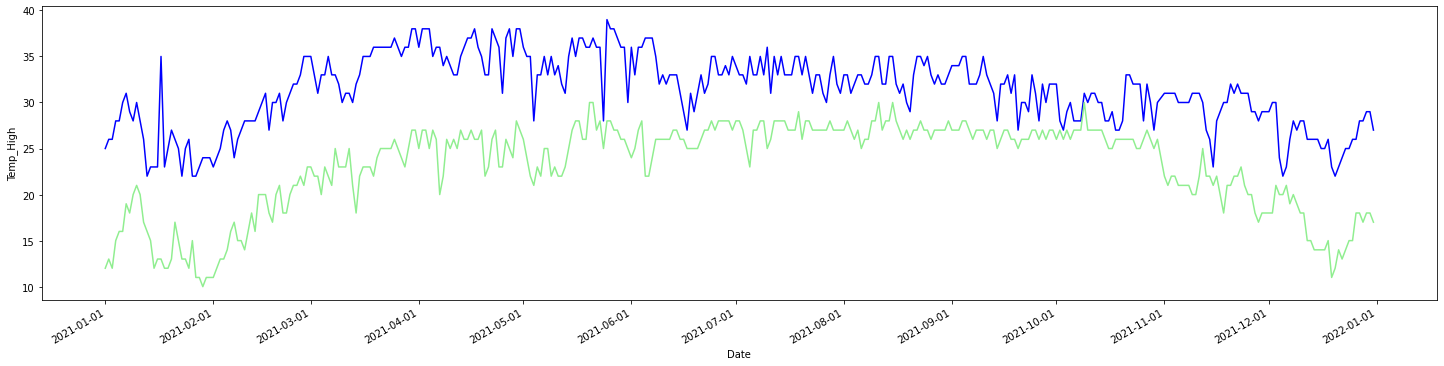

In [5]:
fig, ax = plt.subplots(figsize=(25, 6))


formatter = mdates.DateFormatter("%Y-%m-%d")

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(locator)

ax.plot(x, yh, label='Temperature_High', color = 'blue')
ax.plot(x, yl, label='Temperature_Low', color = 'lightgreen')

plt.xlabel('Date')
plt.ylabel('Temp_High')


### Preparing the data

In [6]:
FullData=hdf[['Temp_High']].values
len(FullData)

364

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()

DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)

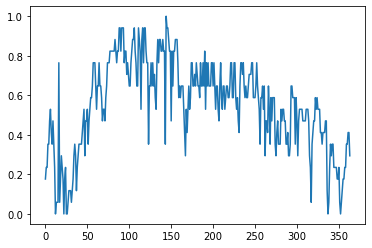

In [8]:
plt.plot(X)

In [9]:
X[0:0]

array([], shape=(0, 1), dtype=float64)

In [10]:
X_samples = list()
y_samples = list()

nRows = len(X)
TimeSteps=10  # next day's Temp_High Prediction is based on last how many past day's Temp_Highs

# Iterate thru the values to create combinations
for i in range(TimeSteps , nRows , 1):
    x_sample = X[i-TimeSteps:i]
    
    y_sample = X[i]
    
    X_samples.append(x_sample)
    y_samples.append(y_sample)

### 3D Reshaping

In [11]:
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
X_data.shape

(354, 10, 1)

In [12]:
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
y_data.shape

(354, 1)

### Testing

In [13]:
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

In [14]:
# Defining Input shapes for LSTM

TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


### Fitting the Deep Learning LSTM model

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [16]:
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes')

Epoch 1/100
70/70 [==============================] - 4s 6ms/step - loss: 0.2705
Epoch 2/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0362
Epoch 3/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0315
Epoch 4/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0224
Epoch 5/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0210
Epoch 6/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 7/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0227
Epoch 8/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0248
Epoch 9/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0182
Epoch 10/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0228
Epoch 11/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0181
Epoch 12/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0196
Epoch 13/100
70/70 [=================

### Generating predictions on testing data

In [17]:
predicted_temp_high = regressor.predict(X_test)
predicted_temp_high = DataScaler.inverse_transform(predicted_temp_high)
predicted_temp_high

array([[25.482067],
       [26.130337],
       [26.464901],
       [27.09483 ],
       [27.57174 ]], dtype=float32)

In [18]:
# Getting the original Temp_High values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
orig

array([[28.],
       [28.],
       [29.],
       [29.],
       [27.]])

### Measuring the Accuracy of predictions

In [19]:
# Accuracy of the predictions
100 - (100*(abs(orig-predicted_temp_high)/orig)).mean()

93.38023744084457

### Visualising the results

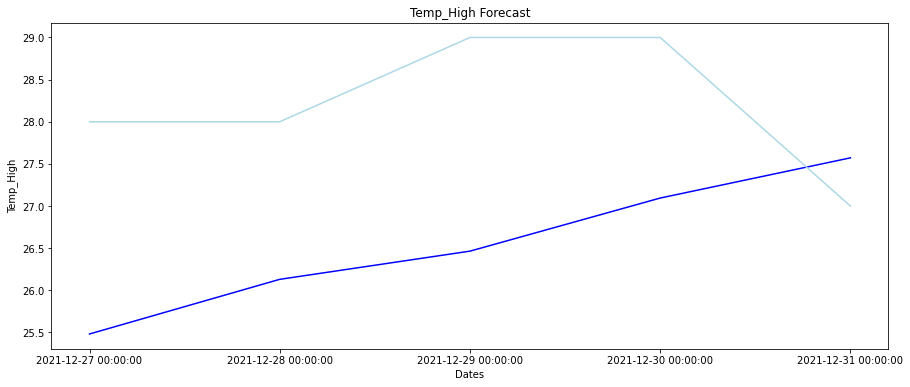

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(predicted_temp_high, label='Predicted Temperature_High', color = 'blue')
ax.plot(orig, label='Original Temp_High', color = 'lightblue')

plt.title('Temp_High Forecast')
plt.xticks(range(TestingRecords), hdf.tail(TestingRecords)['Dates'])
plt.xlabel('Dates')
plt.ylabel('Temp_High')

fig.set_figwidth(15)
fig.set_figheight(6)
plt.show()



### Plotting the predictions for full data

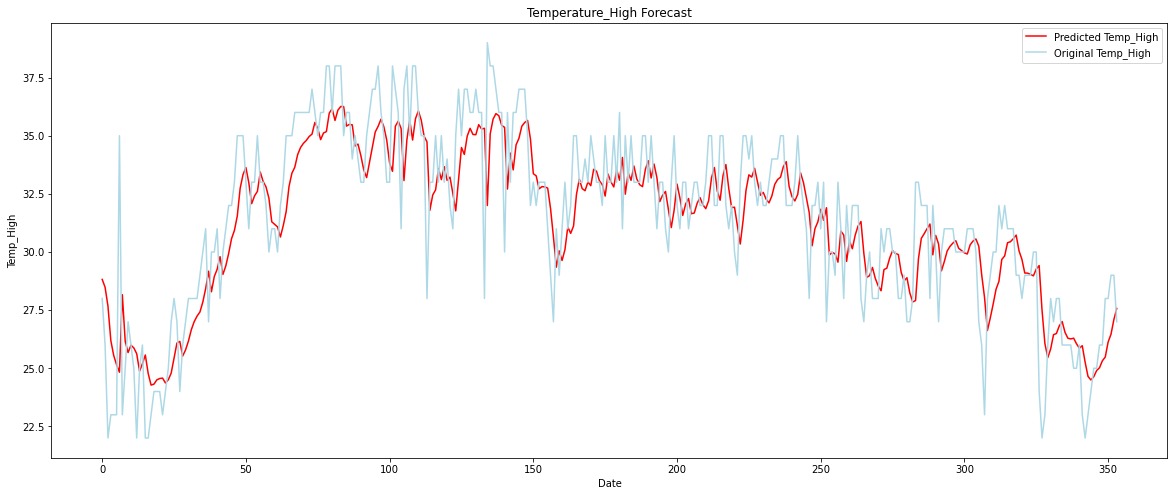

In [21]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

# plotting the full data
plt.plot(FullDataPredictions, color = 'red', label = 'Predicted Temp_High')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Temp_High')


plt.title('Temperature_High Forecast')
plt.xlabel('Date')
plt.ylabel('Temp_High')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

In [22]:
date_1 = datetime.datetime.strptime('2021-12-31', "%Y-%m-%d")

end_date = date_1 + datetime.timedelta(days=1)
ed = end_date.strftime('%Y-%m-%d')
print(ed)

2022-01-01


In [23]:
Last10Days=np.array(FullData[-10:])
 
# Normalizing the data just like we did for training the model
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))
 
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
#############################
 
# Making predictions on data
predicted_Temp_High = regressor.predict(Last10Days)
predicted_Temp_High = DataScaler.inverse_transform(predicted_Temp_High)
print('The predicted temperature for {} is {}'.format(ed, str(predicted_Temp_High).replace('[',"").replace(']',"")))

The predicted temperature for 2022-01-01 is 27.253902
